<img src='img/logo.png' alt='Drawing' style='width:2000px;'/>
<img src='img/_logo.JPG' alt='Drawing' style='width:2000px;'/>

# <font color=blue>4.3 Frame Analysis</font>

In [1]:
# import libraries 
#  ------------------------

import openseespy.opensees as ops
# stuff for plotting
import matplotlib.pyplot as plt
import openseespy.postprocessing.ops_vis as opsv # ops_vis module for opensees
import openseespy.postprocessing.Get_Rendering as opsplt # Get_Rendering module for opensees
# math stuff
import numpy as np

# Define units
#  ------------------------

# Basic Units
m = 1.0
kN = 1.0
sec = 1.0
# Length
mm = m / 1000.0
cm = m / 100.0
inch = 25.4 * mm
ft = 12.0 * inch
# Force
N = kN / 1000.0
kips = kN * 4.448221615
# Mass (tonnes)
tonne = kN * sec ** 2 / m
kg = N * sec ** 2 / m
# Stress (kN/m2 or kPa)
Pa = N / (m ** 2)
kPa = Pa * 1.0e3
MPa = Pa * 1.0e6
GPa = Pa * 1.0e9
ksi = 6.8947573 * MPa
psi = 1e-3 * ksi
# gravitational acceleration
g = 9.81*m/sec**2

In [2]:
# --------------------------------------------------------------------------------------------------
# Example: 2-Story Steel Moment Frame with elastic beam-columnelements
# Element and Node ID conventions:
#	1xy = frame columns with springs at both ends
#	2xy = frame beams with springs at both ends
#	6xy = trusses linking frame and P-delta column
#	7xy = P-delta columns
#	3,xya = frame column rotational springs
#	4,xya = frame beam rotational springs
#	5,xya = P-delta column rotational springs
#	where:
#		x = Pier or Bay #
#		y = Floor or Story #
#		a = an integer describing the location relative to beam-column joint (see description where elements and nodes are defined)

###################################################################################################
#          Define Building Geometry, Nodes, and Constraints											  
###################################################################################################
# define structure-geometry parameters
NStories = 2						# number of stories
NBays = 1						# number of frame bays (excludes bay for P-delta column)
WBay = 360*inch		# bay width
HStory1 = 180*inch		# 1st story height
HStoryTyp = 144*inch		# story height of other stories
HBuilding = HStory1 + (NStories-1)*HStoryTyp	# height of building

# calculate locations of beam/column joints:
Pier1 = 0.0		# leftmost column line
Pier2 = Pier1 + WBay
Pier3 = Pier2 + WBay	# P-delta column line	
Floor1 = 0.0		# ground floor
Floor2 = Floor1 + HStory1
Floor3 = Floor2 + HStoryTyp

# calculate joint offset distance for beam plastic hinges
phlat23 = 0.0		# lateral dist from beam-col joint to loc of hinge on Floor 2

# calculate nodal masses -- lump floor masses at frame nodes
Floor2Weight = 535.0*kips		# weight of Floor 2
Floor3Weight = 525.0*kips		# weight of Floor 3
WBuilding = Floor2Weight + Floor3Weight # total building weight
NodalMass2 = (Floor2Weight/g) / (2.0)	# mass at each node on Floor 2
NodalMass3 = (Floor3Weight/g) / (2.0)	# mass at each node on Floor 3
Negligible = 1e-9	# a very smnumber to avoid problems with zero

In [3]:
def rotLeaningCol(eleID, nodeR, nodeC):

    ###########################################################################################################
    # rotLeaningCol
    # Procedure that creates a zero-stiffness elastic rotational spring for the leaning column
    # and constrains the translations DOFs of the spring.
    # 
    # Formal arguments
    #       eleID   - unique element ID for this zero length rotational spring
    #       nodeR   - node ID which will be retained by the multi-point constraint
    #       nodeC   - node ID which will be constrained by the multi-point constraint
    #
    ##########################################################################################################

    
    # Spring Stiffness
    K = 1e-9*kips/inch

    # Create the material and zero length element (spring)
    ops.uniaxialMaterial('Elastic', eleID, K)
    ops.element('zeroLength', eleID, nodeR, nodeC, '-mat', eleID, '-dir', 3)

    # Constrain the translational DOF with a multi-point constraint
    # retained constrained DOF_1 DOF_2 
    ops.equalDOF(nodeR, nodeC, 1, 2)

In [4]:
def generate_elastic_model():
    
    ###################################################################################################
    #          Set Up & Source Definition									  
    ###################################################################################################
    ops.wipe('all')							# clear memory of past model definitions
    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)	# Define the model builder, ndm = #dimension, ndf = #dofs    

    # define nodes and assign masses to beam-column intersections of frame
    # command:  node nodeID xcoord ycoord -mass mass_dof1 mass_dof2 mass_dof3
    # nodeID convention:  "xy" where x = Pier # and y = Floor # 
    ops.node(11, Pier1, Floor1)
    ops.node(21, Pier2, Floor1)
    ops.node(31, Pier3, Floor1)
    ops.node(12, Pier1, Floor2, '-mass', NodalMass2, Negligible, Negligible)
    ops.node(22, Pier2, Floor2, '-mass', NodalMass2, Negligible, Negligible)
    ops.node(32, Pier3, Floor2),
    ops.node(13, Pier1, Floor3, '-mass', NodalMass3, Negligible, Negligible)
    ops.node(23, Pier2, Floor3, '-mass', NodalMass3, Negligible, Negligible)
    ops.node(33, Pier3, Floor3)
    
    # extra nodes for springs in p-delta columns 
    ops.node(326, Pier3, Floor2)	# zero-stiffness spring will be used on p-delta column
    ops.node(327, Pier3, Floor2)	# zero-stiffness spring will be used on p-delta column
    ops.node(336, Pier3, Floor3)	# zero-stiffness spring will be used on p-delta column
             
    # constrain beam-column joints in a floor to have the same lateral displacement using the "equalDOF" command
    # This is to simulate rigid floor diaphragm
    # command: equalDOF $MasterNodeID $SlaveNodeID $dof1 $dof2...
    dof1 = 1	# constrain movement in dof 1 (x-direction)
    ops.equalDOF(12, 22, dof1)	# Floor 2:  Pier 1 to Pier 2
    ops.equalDOF(13, 23, dof1)	# Floor 3:  Pier 1 to Pier 2
    
    # assign boundary condidtions
    # command:  fix nodeID dxFixity dyFixity rzFixity
    # fixity values: 1 = constrained; 0 = unconstrained
    # fix the base of the building; pin P-delta column at base
    ops.fix(11, 1, 1, 1)
    ops.fix(21, 1, 1, 1)
    ops.fix(31, 1, 1, 0)	# P-delta column is pinned
    
    ###################################################################################################
    #          Define Section Properties and Elements													 
    ###################################################################################################
    
    
    # define material properties
    # Shear material
    fc = 5.0*ksi					# Concrete strength
    Ec = 5000*MPa*(fc/MPa)**0.5		# Young's modulus
    Gc = Ec/(2*(1+0.2))				# Shear modulus
    kv = 5/6						# 5/6 for rectangular sections

    # define column sectionfor Story 1 & 2
    colWidth = 15*inch
    colDepth = 24*inch 
    Acol = colWidth*colDepth		# cross-sectional area
    Icol = 1/12*colWidth*colDepth**2	# moment of inertia
    Avcol = kv*Acol		# shear area for TimoshenkoBeam
    
    # define beam section for Floor 2 & 3
    beamWidth = 15*inch
    beamDepth = 24*inch 
    Abeam = beamWidth*beamDepth		# cross-sectional area (full section properties)
    Ibeam = 1/12*beamWidth*beamDepth**3	# moment of inertia  (full section properties)
    Avbeam = kv*Abeam		# shear area for TimoshenkoBeam
    
    # set up geometric transformations of element
    PDeltaTransf = 1
    ops.geomTransf('PDelta', PDeltaTransf) 	# PDelta transformation
    
    # define column elements using "element" command
    # command: element elasticBeamColumn $eleID $iNode $jNode $secTagI $Lpi $secTagJ $Lpj $E $A $I $transfID -mass $massDens> <-cMass>
    # command: element ElasticTimoshenkoBeam $eleTag $iNode $jNode $E $G $A $Iz $Avy $transfTag <-mass $massDens> <-cMass>
    # note that elasticBeamColumn element does not account for shear deformations (it does not have shear flexibility)
    # eleID convention:  "1xy" where 1 = col, x = Pier #, y = Story #
    # Columns Story 1
    # ops.element('elasticBeamColumn', 111, 11, 12, Acol, Ec, Icol, PDeltaTransf)	# Pier 1
    ops.element('ElasticTimoshenkoBeam', 111, 11, 12, Ec, Gc, Acol, Icol, Avcol, PDeltaTransf)	# Pier 1
    # ops.element('elasticBeamColumn', 121, 21, 22, Acol, Ec, Icol, PDeltaTransf)	# Pier 2
    ops.element('ElasticTimoshenkoBeam', 121, 21, 22, Ec, Gc, Acol, Icol, Avcol, PDeltaTransf)	# Pier 2
    
    # Columns Story 2
    # ops.element('elasticBeamColumn', 112, 12, 13, Acol, Ec, Icol, PDeltaTransf)	# Pier 1
    ops.element('ElasticTimoshenkoBeam', 112, 12, 13, Ec, Gc, Acol, Icol, Avcol, PDeltaTransf)	# Pier 1
    # ops.element('elasticBeamColumn', 122, 22, 23, Acol, Ec, Icol, PDeltaTransf)	# Pier 2
    ops.element('ElasticTimoshenkoBeam', 122, 22, 23, Ec, Gc, Acol, Icol, Avcol, PDeltaTransf)	# Pier 2
    
    # define elastic beam elements
    # eleID convention:  "2xy" where 2 = beam, x = Bay #, y = Floor #
    # Beams Story 1
    # ops.element('elasticBeamColumn',212, 12, 22, Abeam, Ec, Ibeam, PDeltaTransf)
    ops.element('ElasticTimoshenkoBeam',212, 12, 22, Ec, Gc, Abeam, Ibeam, Avbeam, PDeltaTransf)
    # Beams Story 2
    # ops.element('elasticBeamColumn',222, 13, 23, Abeam, Ec, Ibeam, PDeltaTransf)
    ops.element('ElasticTimoshenkoBeam',222, 13, 23, Ec, Gc, Abeam, Ibeam, Avbeam, PDeltaTransf)
    
    # define p-delta columns and rigid links
    TrussMatID = 600			# define a material ID
    Arigid = 1000.0*inch**2		# define area of truss section (make much larger than A of frame elements)
    Irigid = 100000.0*inch**4 	# moment of inertia for p-delta columns  (make much larger than I of frame elements)
    ops.uniaxialMaterial('Elastic', TrussMatID, Ec)		# define truss material
    # rigid links
    # command: element truss $eleID $iNode $jNode $A $materialID
    # eleID convention:  6xy, 6 = truss link, x = Bay #, y = Floor #
    ops.element('truss', 622, 22, 32, Arigid, TrussMatID)	# Floor 2
    ops.element('truss', 623, 23, 33, Arigid, TrussMatID)	# Floor 3
    
    # p-delta columns
    # eleID convention:  7xy, 7 = p-delta columns, x = Pier #, y = Story #
    ops.element('elasticBeamColumn', 731, 31, 326, Arigid, Ec, Irigid, PDeltaTransf)	# Story 1
    ops.element('elasticBeamColumn', 732, 327, 336, Arigid, Ec, Irigid, PDeltaTransf)	# Story 2
    
    # define p-delta column spring: zero-stiffness elastic spring	
    #Spring ID: "5xya" where 5 = leaning column spring, x = Pier #, y = Story #, a = location in story
    # "a" convention: 1 = bottom of story, 2 = top of story
    # rotLeaningCol	ElemID ndR ndC 
    rotLeaningCol(5312, 32, 326)	# top of Story 1
    rotLeaningCol(5321, 32, 327)	# bottom of Story 2
    rotLeaningCol(5322, 33, 336)	# top of Story 2

    # apply gravity loads
    # This command is used to construct a TimeSeries object which represents the relationship between the time in the domain, 
    # t, and the load factor applied to the loads, 
    # λ, in the load pattern with which the TimeSeries object is associated, i.e. λ=F(t).
    # command: timeSeries(tstype, tstag, *tsArgs)
    ops.timeSeries("Constant", 1)
    
    # The pattern command is used to construct a LoadPattern and add it to the Domain. 
    # Each LoadPattern in OpenSees has a TimeSeries associated with it. 
    # In addition it may contain ElementLoads, NodalLoads and SinglePointConstraints. 
    # Some of these SinglePoint constraints may be associated with GroundMotions.
    # command: pattern(patternType, patternTag, *patternArgs)
    ops.pattern('Plain', 101, 1)
    
    # # point loads on leaning column nodes
    # # command: load node Fx Fy Mz
    P_PD2 = -398.02*kips	# Floor 2
    P_PD3 = -391.31*kips	# Floor 3
    ops.load(32, 0.0, P_PD2, 0.0)		# Floor 2
    ops.load(33, 0.0, P_PD3, 0.0)		# Floor 3
    
    # distributed loads on frame column nodes
    w_F2 = (-1.0*Floor2Weight-P_PD2)/WBay	# load on each frame node in Floor 2
    w_F3 = (-1.0*Floor3Weight-P_PD3)/WBay	# load on each frame node in Floor 3
    # Floor 2 loads
    ops.eleLoad('-ele', 212, '-type', '-beamUniform', w_F2, 0)
    # Floor 3 loads
    ops.eleLoad('-ele', 222, '-type', '-beamUniform', w_F3, 0)

In [5]:
def do_gravity(pflag = 0):
    ops.wipeAnalysis() # Remove previous analysis objects
    
    # Gravity-analysis: load-controlled static analysis
    Tol = 1e-8 # convergence tolerance for test
    NstepGravity = 500
    DGravity = 1/NstepGravity
    ops.integrator('LoadControl', DGravity) # determine the next time step for an analysis
    ops.numberer('Plain') # renumber dof's to minimize band-width (optimization), if you want to
    ops.system('BandGeneral') # how to store and solve the system of equations in the analysis
    ops.constraints('Transformation') # how it handles boundary conditions
    ops.test('NormDispIncr', Tol, 50) # determine if convergence has been achieved at the end of an iteration step
    ops.algorithm('Newton') # use Newton's solution algorithm: updates tangent stiffness at every iteration
    ops.analysis('Static') # define type of analysis static or transient
    ops.analyze(NstepGravity) # apply gravity

    # maintain constant gravity loads and reset time to zero
    ops.loadConst('-time', 0.0)
    print("Model Built")
    
    # Get the reaction forces in vertical direction, this is for verification purposes
    ops.reactions('-dynamic', '-rayleigh')
    
    if pflag == 1:
        F_tot=0
        for node in ops.getNodeTags():
            forces = np.array(ops.nodeReaction(node))
            F_tot += forces
            print('Nodal reaction for node %d: Fx=%.3f, Fy=%.3f, M=%.3f' %(node,forces[0],forces[1],forces[2]))
        print('Total reaction: Fx=%.3f, Fy=%.3f, M=%.3f' %(F_tot[0],F_tot[1],F_tot[2]))
    
    # print ele forces
    eleForces = {}
    for ele in ops.getEleTags():
        forces = ops.eleForce(ele)
        eleForces[ele] = np.array(forces)
    
    nodalDisps = {}
    for node in ops.getNodeTags():
        disps = ops.nodeDisp(node)
        nodalDisps[node] = np.array(disps)
        
    return eleForces, nodalDisps

In [6]:
def do_rsa(nModes, method = 'CQC', xi = 0.05, aDir = 1):
    # nModes: number of modes to be used for analysis
    # method: modal combination method 'CQC' or 'SRSS'
    # xi: damping for CQC modal combination
    # aDir: analysis direction
    
    # we need a function to perform CQC combination of modes.
    # CQC function
    def CQC(mu, lambdas, dmp):
        # mu: results of a node or an element for each mode (forces, displacements, deformations etc.)
        # lambdas: eigenvalues
        # dmp: damping ratio for modes
    	u = 0.0
    	ne = len(lambdas)
    	for i in range(ne):
    		for j in range(ne):
    			di = dmp[i]
    			dj = dmp[j]
    			bij = lambdas[i]/lambdas[j]
    			rho = ((8.0*((di*dj)**0.5)*(di+bij*dj)*(bij**(3.0/2.0))) /
    				((1.0-bij**2.0)**2.0 + 4.0*di*dj*bij*(1.0+bij**2.0) + 
    				4.0*(di**2.0 + dj**2.0)*bij**2.0))
    			u += mu[i] * mu[j] * rho
    	return (u)**0.5

    def SRSS(mu, nModes):
        # mu: results of a node or an element for each mode (forces, displacements, deformations etc.)
    	u = 0.0
    	for i in range(nModes):
            u += mu[i]**2
    	return (u)**0.5
    
    # Import spectrum
    data = np.loadtxt('tools//Target_Spectrum.txt')
    Periods = data[:,0]
    Sa = data[:,1]
    
    # some settings for the response spectrum analysis
    tsTag = 2 # use the timeSeries 1 as response spectrum function
    direc = 1 # excited DOF = Ux
    ops.timeSeries("Path",tsTag,"-time",*Periods,"-values",*Sa,"-factor",9.806)
    
    # define new analysis settings
    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.system("UmfPack")
    ops.test("NormUnbalance", 0.0001, 10)
    ops.algorithm("Linear")
    ops.integrator("LoadControl", 0.0)
    ops.analysis("Static")
    
    # first compute the modal properties, and noramlize modes.
    nEigen = 2								        # desired number of modes to calculate 
    lambdas = ops.eigen('-genBandArpack', nEigen)	# eigenvalue analysis for nEigen modes
    ops.modalProperties("-unorm")
    # currently we use the same damping for each mode (5%)
    dmp = [xi]*nEigen
    
    # ========================================================================
    # run a response spectrum analysis mode-by-mode.
    # grab results during the loop
    # then do modal combination in post-processing.
    # ========================================================================
    ModalForces = {}
    for ele in ops.getEleTags():
        ModalForces[ele] = []
        
    ModalDisps = {}
    for node in ops.getNodeTags():
        ModalDisps[node] = []
        
    for i in range(len(lambdas)):
        ops.responseSpectrum(tsTag, aDir, '-mode', i+1)
        for ele in ops.getEleTags():
            forces = np.array(ops.eleResponse(ele, 'force'))
            ModalForces[ele].append(forces)
        for node in ops.getNodeTags():
            disps = np.array(ops.nodeDisp(node))
            ModalDisps[node].append(disps)
    
    # post process the results doing the CQC modal combination for the My response (3rd column in section forces)
    eleForces = {}
    for ele in ops.getEleTags():
        if method == 'CQC':
            forces = CQC(ModalForces[ele], lambdas, dmp)
        elif method == 'SRSS':
            forces = SRSS(ModalForces[ele], nModes)
        eleForces[ele] = forces
    
    nodalDisps = {}
    for node in ops.getNodeTags():
        if method == 'CQC':
            disps = CQC(ModalDisps[node], lambdas, dmp)
        elif method == 'SRSS':
            disps = SRSS(ModalDisps[node], nModes)

        nodalDisps[node] = disps
    
    return eleForces, nodalDisps

No Model_ODB specified, trying to get data from the active model.
2D model


<IPython.core.display.Javascript object>


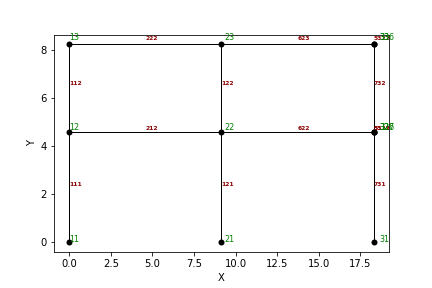

<IPython.core.display.Javascript object>


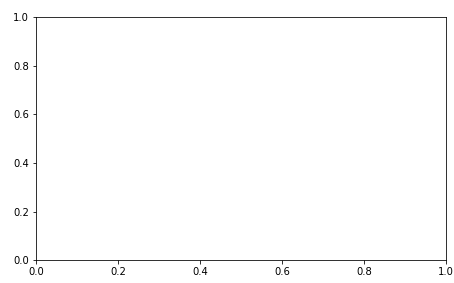

<IPython.core.display.Javascript object>


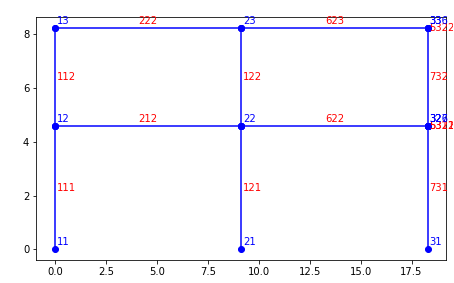

In [7]:
# Display the Numerical Model for Elastic Frame
generate_elastic_model()

# plot model with tag lebels
opsplt.plot_model('nodes','elements')

# plot model with tag lebels
szer, wys = 16., 10.
fig = plt.figure(figsize=(szer/2.54, wys/2.54))
fig.subplots_adjust(left=.08, bottom=.08, right=.985, top=.94)
ax1 = plt.subplot(111)
opsv.plot_model()

No Model_ODB specified to plot modeshapes
2D model


Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology
# MODAL ANALYSIS REPORT

* 1. DOMAIN SIZE:
# This is the size of the problem: 2 for 2D problems, 3 for 3D problems.
2


* 2. EIGENVALUE ANALYSIS:
#          MODE        LAMBDA         OMEGA     FREQUENCY        PERIOD
# ------------- ------------- ------------- ------------- -------------
              1       47.7107       6.90729       1.09933      0.909645
              2       780.068       27.9297       4.44515      0.224964


* 3. TOTAL MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including the masses at fixed DOFs (if any).
#            MX            MY           RMZ
# ------------- ------------- -------------
        480.644         4e-09       1607.52


* 4. TOTAL FREE MASS OF THE STRUCTURE:
# The total masses (translational and rotational) of the structure
# including only the masses at free DOFs.
#            MX            MY   

<IPython.core.display.Javascript object>


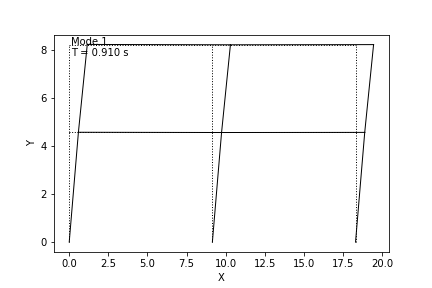

No Model_ODB specified to plot modeshapes
2D model


<IPython.core.display.Javascript object>


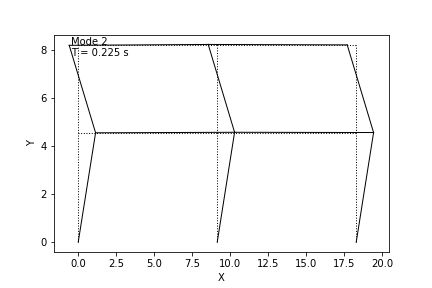

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [8]:
# Modal Analyses of the elastic frame
# In the past version of OpenSees there was no particular function to calculate modal properties
# Hence ,I was using my own function which you can find it here:
# https://github.com/volkanozsarac/ModalAnalysis-OpenSeespy.git
# Now there is a brand new function developed by Dr. Massimo Petracca
# documentation is here: 
# https://opensees.github.io/OpenSeesDocumentation/user/manual/analysis/modalProperties.html

generate_elastic_model() # generate a clean model
nModes = 2 # desired number of modes to calculate 
lambdas = ops.eigen(nModes) # eigenvalue analysis for nEigen modes
ops.modalProperties("-print", "-file", "ModalReport.txt", "-unorm")

####  Display specific mode shape with scale factor of 20 using the active model
# Sometimes modalProperties command do not work well, just plot modeshapes after running it
opsplt.plot_modeshape(1, 20)
opsplt.plot_modeshape(2, 20)

In [9]:
# Response Spectrum Analysis of the elastic frame  
generate_elastic_model() # generate a clean model
rsaForces, rsaDisps = do_rsa(nModes, 'SRSS')

Using ResponseSpectrumAnalysis - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


In [10]:
# Static Analysis of the elastic frame under gravity loads
generate_elastic_model() # generate a clean model
gravityForces, gravityDisps = do_gravity(pflag = 1)

Model Built
Nodal reaction for node 11: Fx=42.270, Fy=602.000, M=-61.800
Nodal reaction for node 12: Fx=154.526, Fy=0.000, M=0.000
Nodal reaction for node 13: Fx=-196.795, Fy=0.000, M=0.000
Nodal reaction for node 21: Fx=-42.270, Fy=602.000, M=61.800
Nodal reaction for node 22: Fx=-154.526, Fy=0.000, M=0.000
Nodal reaction for node 23: Fx=196.795, Fy=0.000, M=0.000
Nodal reaction for node 31: Fx=-0.000, Fy=3511.115, M=-0.000
Nodal reaction for node 32: Fx=0.000, Fy=1770.481, M=0.000
Nodal reaction for node 33: Fx=-0.000, Fy=1740.634, M=0.000
Nodal reaction for node 326: Fx=0.000, Fy=-3511.115, M=0.000
Nodal reaction for node 327: Fx=-0.000, Fy=1740.634, M=-0.000
Nodal reaction for node 336: Fx=0.000, Fy=-1740.634, M=-0.000
Total reaction: Fx=-0.000, Fy=4715.115, M=0.000


In [11]:
def generate_inelastic_model():
    
    ###################################################################################################
    #          Set Up & Source Definition									  
    ###################################################################################################
    ops.wipe('all')							# clear memory of past model definitions
    ops.model('BasicBuilder', '-ndm', 2, '-ndf', 3)	# Define the model builder, ndm = #dimension, ndf = #dofs    

    # define nodes and assign masses to beam-column intersections of frame
    # command:  node nodeID xcoord ycoord -mass mass_dof1 mass_dof2 mass_dof3
    # nodeID convention:  "xy" where x = Pier # and y = Floor # 
    ops.node(11, Pier1, Floor1)
    ops.node(21, Pier2, Floor1)
    ops.node(31, Pier3, Floor1)
    ops.node(12, Pier1, Floor2, '-mass', NodalMass2, Negligible, Negligible)
    ops.node(22, Pier2, Floor2, '-mass', NodalMass2, Negligible, Negligible)
    ops.node(32, Pier3, Floor2),
    ops.node(13, Pier1, Floor3, '-mass', NodalMass3, Negligible, Negligible)
    ops.node(23, Pier2, Floor3, '-mass', NodalMass3, Negligible, Negligible)
    ops.node(33, Pier3, Floor3)
    
    # extra nodes for springs in p-delta columns 
    ops.node(326, Pier3, Floor2)	# zero-stiffness spring will be used on p-delta column
    ops.node(327, Pier3, Floor2)	# zero-stiffness spring will be used on p-delta column
    ops.node(336, Pier3, Floor3)	# zero-stiffness spring will be used on p-delta column
             
    # constrain beam-column joints in a floor to have the same lateral displacement using the "equalDOF" command
    # This is to simulate rigid floor diaphragm
    # command: equalDOF $MasterNodeID $SlaveNodeID $dof1 $dof2...
    dof1 = 1	# constrain movement in dof 1 (x-direction)
    ops.equalDOF(12, 22, dof1)	# Floor 2:  Pier 1 to Pier 2
    ops.equalDOF(13, 23, dof1)	# Floor 3:  Pier 1 to Pier 2
    
    # assign boundary condidtions
    # command:  fix nodeID dxFixity dyFixity rzFixity
    # fixity values: 1 = constrained; 0 = unconstrained
    # fix the base of the building; pin P-delta column at base
    ops.fix(11, 1, 1, 1)
    ops.fix(21, 1, 1, 1)
    ops.fix(31, 1, 1, 0)	# P-delta column is pinned
    
    ###################################################################################################
    #          Define Section Properties and Elements													 
    ###################################################################################################
    # Define materials for column sections
    # ------------------------------------
    # Core concrete (confined)
    confined_concrete_mat = 1
    fcC_col =  -6.0*ksi # compressive concrete strength
    ecC_col = -0.004 # stain at compressive concrete strength
    ecuC_col = -0.014 # ultimate strain
    EcC_col = 5000*MPa*(np.abs(fcC_col)/MPa)**0.5 # youngs modulus
    fctC = 0.56*MPa*(np.abs(fcC_col)/MPa)**0.5 # tensile concrete strength
    ectC = fctC/EcC_col # cracking strain
    beta = 0.1 # floating point value defining the exponential curve parameter to
    # define the residual stress (as a factor of $ft) at $etu
    ops.uniaxialMaterial('Concrete04', confined_concrete_mat, fcC_col, ecC_col, ecuC_col, EcC_col, fctC, ectC, beta)
    
    # Cover concrete (unconfined)
    cover_concrete_mat = 2
    fcU_col =  -5.0*ksi
    ecU_col = -0.002
    ecuU_col = -0.014
    EcU_col = 5000*MPa*(np.abs(fcU_col)/MPa)**0.5
    fctU = 0.56*MPa*(np.abs(fcU_col)/MPa)**0.5 # tensile concrete strength
    ectU = fctU/EcU_col # cracking strain
    ops.uniaxialMaterial('Concrete04', cover_concrete_mat, fcU_col, ecU_col, ecuU_col, EcU_col, fctU, ectU, beta)
    
    # Reinforcing steel 
    steel_mat = 3
    fsy = 60.0*ksi      # Yield stress
    Es = 30000.0*ksi    # Young's modulus
    b = 0.01 # train-hardening ratio (ratio between post-yield tangent and initial elastic tangent)
    # parameters to control the transition from elastic to plastic branches
    R0=20 
    cR1=0.925
    cR2=0.15
    ops.uniaxialMaterial('Steel02', steel_mat, fsy, Es, b, R0, cR1, cR2)

    #  define column section for Story 1 & 2
    # --------------------------------------
    colWidth = 15*inch
    colDepth = 24*inch 
    cover = 1.5*inch
    As = 0.60*inch**2     # area of no. 7 bars
    
    # some variables derived from the parameters
    y1 = colDepth/2.0
    z1 = colWidth/2.0

    # Start definition of a fiber section with Tag 1
    FiberSec = 1
    ops.section('Fiber', FiberSec)

    # Create the concrete core fibers
    # patch rect $matTag $numSubdivY $numSubdivZ $yI $zI $yJ $zJ
    ops.patch('rect',confined_concrete_mat, 10, 1, cover-y1, cover-z1, y1-cover, z1-cover)

    # Create the concrete cover fibers (top, bottom, left, right)
    ops.patch('rect',cover_concrete_mat,10,1 ,-y1, z1-cover, y1, z1)
    ops.patch('rect',cover_concrete_mat,10,1 ,-y1, -z1, y1, cover-z1)
    ops.patch('rect',cover_concrete_mat,2,1 ,-y1, cover-z1, cover-y1, z1-cover)
    ops.patch('rect',cover_concrete_mat,2,1 ,y1-cover, cover-z1, y1, z1-cover)

    # Create the reinforcing fibers (left, middle, right)
    ops.layer('straight', steel_mat, 3, As, y1-cover, z1-cover, y1-cover, cover-z1)
    ops.layer('straight', steel_mat, 2, As, 0.0     , z1-cover, 0.0     , cover-z1)
    ops.layer('straight', steel_mat, 3, As, cover-y1, z1-cover, cover-y1, cover-z1)
    
    # Shear material
    kv = 5/6 # shear area factor timoshenko beam
    Gc_col = EcU_col/(2*(1+0.2))
    Avcol = colWidth*colDepth*kv # shear area
    shear_mat = 4
    ops.uniaxialMaterial('Elastic', shear_mat, Gc_col*Avcol)
    ColSec = 2
    ops.section('Aggregator', ColSec, shear_mat, 'Vy', '-section', FiberSec)
    
    # Let's use elastic element for beams with the same section dimensions for the column
    Abeam = colWidth*colDepth		# cross-sectional area (full section properties)
    Ibeam = 1/12*colWidth*colDepth**3	# moment of inertia  (full section properties)
    Avbeam = Abeam*kv		# shear area for TimoshenkoBeam
    
    # Define integration scheme for the forcebeamcolumn element
    intTag = 1
    
    ## Lobatto integration scheme can be used
    # numIntPoints = 5 # Number of integration points along length of element
    # ops.beamIntegration('Lobatto', intTag, ColSec, numIntPoints)
    
    # Or HingeRadau scheme to specify the plastic hinge length.
    # ops.beamIntegration HingeRadau, tag secI lpI secJ lpJ secE
    # note that we are going to use an inelastic section for interior sections as well (secE)
    Lpl = 0.5 * colDepth # lets take the half of the section depth as an example.
    ops.beamIntegration('HingeRadau', intTag, ColSec, Lpl, ColSec, Lpl, ColSec)
    
    # define beam section for Floor 2 & 3
    Ec = EcU_col
    Gc = Gc_col
    Abeam = 30.0*inch**2		# cross-sectional area (full section properties)
    Ibeam = 3620.0*inch**4	# moment of inertia  (full section properties)
    Avbeam = kv*Abeam		# shear area for TimoshenkoBeam
    
    # set up geometric transformations of element
    PDeltaTransf = 1
    ops.geomTransf('PDelta', PDeltaTransf) 	# PDelta transformation
    
    # define column elements using "element" command
    # command: element elasticBeamColumn $eleID $iNode $jNode $secTagI $Lpi $secTagJ $Lpj $E $A $I $transfID -mass $massDens> <-cMass>
    # command: element ElasticTimoshenkoBeam $eleTag $iNode $jNode $E $G $A $Iz $Avy $transfTag <-mass $massDens> <-cMass>
    # note that elasticBeamColumn element does not account for shear deformations (it does not have shear flexibility)
    # eleID convention:  "1xy" where 1 = col, x = Pier #, y = Story #
    # Columns Story 1
    ops.element('forceBeamColumn', 111, 11, 12, PDeltaTransf, intTag)	# Pier 1
    ops.element('forceBeamColumn', 121, 21, 22, PDeltaTransf, intTag)	# Pier 2
    
    # Columns Story 2
    ops.element('forceBeamColumn', 112, 12, 13, PDeltaTransf, intTag)	# Pier 1
    ops.element('forceBeamColumn', 122, 22, 23, PDeltaTransf, intTag)	# Pier 2
    
    # define elastic beam elements
    # eleID convention:  "2xy" where 2 = beam, x = Bay #, y = Floor #
    # Beams Story 1
    # ops.element('elasticBeamColumn',212, 12, 22, Abeam, Ec, Ibeam, PDeltaTransf)
    ops.element('ElasticTimoshenkoBeam',212, 12, 22, Ec, Gc, Abeam, Ibeam, Avbeam, PDeltaTransf)
    # Beams Story 2
    # ops.element('elasticBeamColumn',222, 13, 23, Abeam, Ec, Ibeam, PDeltaTransf)
    ops.element('ElasticTimoshenkoBeam',222, 13, 23, Ec, Gc, Abeam, Ibeam, Avbeam, PDeltaTransf)
    
    # define p-delta columns and rigid links
    TrussMatID = 600			# define a material ID
    Arigid = 1000.0*inch**2		# define area of truss section (make much larger than A of frame elements)
    Irigid = 100000.0*inch**4 	# moment of inertia for p-delta columns  (make much larger than I of frame elements)
    ops.uniaxialMaterial('Elastic', TrussMatID, Ec)		# define truss material
    # rigid links
    # command: element truss $eleID $iNode $jNode $A $materialID
    # eleID convention:  6xy, 6 = truss link, x = Bay #, y = Floor #
    ops.element('truss', 622, 22, 32, Arigid, TrussMatID)	# Floor 2
    ops.element('truss', 623, 23, 33, Arigid, TrussMatID)	# Floor 3
    
    # p-delta columns
    # eleID convention:  7xy, 7 = p-delta columns, x = Pier #, y = Story #
    ops.element('elasticBeamColumn', 731, 31, 326, Arigid, Ec, Irigid, PDeltaTransf)	# Story 1
    ops.element('elasticBeamColumn', 732, 327, 336, Arigid, Ec, Irigid, PDeltaTransf)	# Story 2
    
    # define p-delta column spring: zero-stiffness elastic spring	
    #Spring ID: "5xya" where 5 = leaning column spring, x = Pier #, y = Story #, a = location in story
    # "a" convention: 1 = bottom of story, 2 = top of story
    # rotLeaningCol	ElemID ndR ndC 
    rotLeaningCol(5312, 32, 326)	# top of Story 1
    rotLeaningCol(5321, 32, 327)	# bottom of Story 2
    rotLeaningCol(5322, 33, 336)	# top of Story 2

    # apply gravity loads
    # This command is used to construct a TimeSeries object which represents the relationship between the time in the domain, 
    # t, and the load factor applied to the loads, 
    # λ, in the load pattern with which the TimeSeries object is associated, i.e. λ=F(t).
    # command: timeSeries(tstype, tstag, *tsArgs)
    ops.timeSeries("Constant", 1)
    
    # The pattern command is used to construct a LoadPattern and add it to the Domain. 
    # Each LoadPattern in OpenSees has a TimeSeries associated with it. 
    # In addition it may contain ElementLoads, NodalLoads and SinglePointConstraints. 
    # Some of these SinglePoint constraints may be associated with GroundMotions.
    # command: pattern(patternType, patternTag, *patternArgs)
    ops.pattern('Plain', 101, 1)
    
    # point loads on leaning column nodes
    # command: load node Fx Fy Mz
    P_PD2 = -398.02*kips	# Floor 2
    P_PD3 = -391.31*kips	# Floor 3
    ops.load(32, 0.0, P_PD2, 0.0)		# Floor 2
    ops.load(33, 0.0, P_PD3, 0.0)		# Floor 3
    
    # distributed loads on frame column nodes
    w_F2 = (-1.0*Floor2Weight-P_PD2)/WBay	# load on each frame node in Floor 2
    w_F3 = (-1.0*Floor3Weight-P_PD3)/WBay	# load on each frame node in Floor 3
    # Floor 2 loads
    ops.eleLoad('-ele', 212, '-type', '-beamUniform', w_F2, 0)
    # Floor 3 loads
    ops.eleLoad('-ele', 222, '-type', '-beamUniform', w_F3, 0)

In [12]:
def do_nspa(dmax, ctrlNode, ctrlDOF, nSteps, IOflag=0):
    """
    Procedure to carry out a non-cylic pushover of a model
    Args:
        dmax:        Maximum displacement to run analysis
        ctrlNode:    Node to control with the displacement integrator
        ctrlDOF:     DOF the loading is applied
        nSteps:      Number of steps
        IOflag:      Option to print details on screen (default = 0)
                     1; print analysis info at each analysis step

    Returns:

    """

    ops.wipeAnalysis()
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    
    print("SinglePush: Push node %d to %.3f m in DOF: %d" % (ctrlNode, dmax, ctrlDOF))
    LoadFactor = [0]
    DispCtrlNode = [0]
    # Test Types
    test = {0: 'EnergyIncr', 1: 'NormDispIncr', 2: 'RelativeEnergyIncr', 3: 'RelativeNormUnbalance',
            4: 'RelativeNormDispIncr', 5: 'NormUnbalance'}
    # Algorithm Types
    algorithm = {0: 'Newton', 1: 'KrylovNewton', 2: 'SecantNewton', 3: 'RaphsonNewton', 4: 'PeriodicNewton', 5: 'BFGS',
                 6: 'Broyden', 7: 'NewtonLineSearch'}
    # Integrator Types
    integrator = {0: 'DisplacementControl', 1: 'LoadControl', 2: 'Parallel DisplacementControl',
                  3: 'Minimum Unbalanced Displacement Norm', 4: 'Arc-Length Control'}

    tol = 1e-12  # Set the tolerance to use during the analysis
    iterInit = 10  # Set the initial max number of iterations
    maxIter = 1000  # Set the max number of iterations to use with other integrators
    dU = dmax / (1.0 * nSteps)
    ops.test(test[0], tol, iterInit)  # lets start with energyincr as test
    ops.algorithm(algorithm[0])
    ops.integrator(integrator[0], ctrlNode, ctrlDOF, dU)
    ops.analysis('Static')

    # Set the initial values to start the while loop
    ok = 0.0
    step = 1.0
    loadf = 1.0
    # This feature of disabling the possibility of having a negative loading has been included.
    # This has been adapted from a similar script by Prof. Garbaggio

    i = 1  # counter for the tests, if the analysis fails starts with new test directly
    j = 0  # counter for the algorithm

    current_test = test[0]
    current_algorithm = algorithm[0]

    while step <= nSteps and ok == 0 and loadf > 0:
        ok = ops.analyze(1)

        # If the analysis fails, try the following changes to achieve convergence
        while ok != 0:
            if j == 7:  # this is the final algorithm to try, if the analysis did not converge
                j = 0;
                i += 1  # reset the algorithm to use
                if i == 6:  # we have tried everything
                    break

            j += 1  # change the algorithm

            if j < 3:
                ops.algorithm(algorithm[j], '-initial')

            else:
                ops.algorithm(algorithm[j])

            ops.test(test[i], tol, maxIter)
            ok = ops.analyze(1)
            current_test = test[i];
            current_algorithm = algorithm[j]

        loadf = ops.getTime()
        step += 1.0
        LoadFactor.append(loadf)
        DispCtrlNode.append(ops.nodeDisp(ctrlNode, ctrlDOF))

        # Print the current displacement
        if IOflag >= 1:
            print('Current Test:', current_test, '| Current Algorithm:', current_algorithm,
                  "| Control Disp:", "{:.3f}".format(ops.nodeDisp(ctrlNode, ctrlDOF)),
                  "| Load Factor:", "{:.0f}".format(loadf))

    if ok != 0:
        print("Displacement Control Analysis is FAILED")
        print('-------------------------------------------------------------------------')

    else:
        print("Displacement Control Analysis is SUCCESSFUL")
        print('-------------------------------------------------------------------------')

    if loadf <= 0:
        print("Stopped because of Load factor below zero:", loadf)
        print('------------------------------------------------------------------------')

    return LoadFactor, DispCtrlNode
        

In [13]:
def do_nrha(tNode, bNode, Dt, Tmax, Dc, pflag=0):
    """
    Function to perform Non-linear Response History Analysis
    Args:
        tNode:    top nodes for the drift calculation
        bNode:    bottom nodes for the drift calculation
        Dt:       Analysis time step
        Tmax:     Length of the record (including padding of 0's)
        Dc:       Drift capacity for pier drift (%)
        pflag:    Flag to print stuff if necessary

    Returns:
        mdrft:    Peak Interstorey Drifts [%]
    """
    # Set some analysis settings
    ops.wipeAnalysis()
    ops.constraints('Transformation')
    ops.numberer('Plain')
    ops.system('BandGeneral')
    
    # Define the Initial Analysis Parameters
    testType = 'NormDispIncr'  # Set the initial test type (default)
    tolInit = 1.0e-6  # Set the initial Tolerance, so it can be referred back to (default)
    iterInit = 50  # Set the initial Max Number of Iterations (default)
    algorithmType = 'KrylovNewton'  # Set the initial algorithm type (default)
    
    # Parameters required in Newmark Integrator
    # gamma = 1/2, beta = 1/4 --> Average Acceleration Method; Unconditionally stable
    # gamma = 1/2, beta = 1/6 --> Linear Acceleration Method; Unconditionally stable if Dt / T > 0.551
    gamma = 0.5
    beta = 0.25  

    # Parameters required in Hilber-Hughes-Taylor (HHT) integrator
    # alpha = 1.0 = Newmark Method. smaller alpha means greater numerical damping. 
    # 0.67<alpha<1.0 # recommended. Leave beta and gamma as default for unconditional stability.
    alpha = 0.7 
    
    # Set up analysis parameters
    cIndex = 0  # Initially define the control index (-1 for non-converged, 0 for stable, 1 for global collapse)
    controlTime = 0.0  # Start the controlTime
    ok = 0  # Set the convergence to 0 (initially converged)
    mflr = 0  # Set the initial pier collapse location
    Mdrft = 0.0  # Set initially the maximum of all storey drifts

    # Set up the storey drift values
    h = []
    mdrft = []
            
    for i in range(len(tNode)):
        # Find the coordinates of the nodes in Global Y (2)
        top2 = ops.nodeCoord(tNode[i], 2)
        bot2 = ops.nodeCoord(bNode[i], 2)
        dist = top2 - bot2
        h.append(dist)  # Current pier height
        mdrft.append(0.0)  # We will populate the lists with zeros initially
        if dist == 0: print("WARNING: Zerolength found in drift check")

    # Run the actual analysis now
    while cIndex == 0 and controlTime <= Tmax and ok == 0:
        # Set the default analysis parameters
        ops.integrator('Newmark', gamma, beta)
        ops.test(testType, tolInit, iterInit)
        ops.algorithm(algorithmType)
        ops.analysis('Transient')

        # Do the analysis
        ok = ops.analyze(1, Dt)  # Run a step of the analysis
        controlTime = ops.getTime()  # Update the control time
        if pflag == 2: print("Completed %.2f of %.2f seconds" % (controlTime, Tmax))

        # If the analysis fails, try the following changes to achieve convergence
        # Analysis will be slower in here though...
        k = 0  # counter for the integrators
        while k < 2 and ok != 0:
            if k == 1:
                ops.integrator('HHT', alpha)  # Hail Mary... Bless the analysis with thy damping!
                print(" ~~~ Changing integrator to Hilber-Hughes-Taylor (HHT) from Newmark at %.2f......" % controlTime)
            # First,  change the timestep to achieve convergence...
            if ok != 0:
                print(" ~~~ Failed at %.2f - Reduced timestep by half......" % controlTime)
                Dtt = 0.5 * Dt
                ok = ops.analyze(1, Dtt)

            if ok != 0:
                print(" ~~~ Failed at %.2f - Reduced timestep by quarter......" % controlTime)
                Dtt = 0.25 * Dt
                ok = ops.analyze(1, Dtt)
            
            # Next, change the algorithm with reduced timestep to achieve convergence...
            if ok != 0:
                print(" ~~~ Failed at %.2f - Trying Broyden......" % controlTime)
                ops.algorithm('Broyden', 8)
                ok = ops.analyze(1, Dtt)

            if ok != 0:
                print(" ~~~ Failed at %.2f - Trying Newton with Initial Tangent......" % controlTime)
                ops.algorithm('Newton', '-initial')
                ok = ops.analyze(1, Dtt)

            if ok != 0:
                print("Failed at %.2f - Trying NewtonWithLineSearch......" % controlTime)
                ops.algorithm('NewtonLineSearch', 0.8)
                ok = ops.analyze(1, Dtt)

            # Next change the algorithm with both timestep and tolerance reduction, if this doesn't work
            # in bocca al lupo
            if ok != 0:
                print(
                    " ~~~ Failed at %.2f - Trying Broyden, reduced timestep & relaxed convergence......" % controlTime)
                ops.test(testType, tolInit * 0.1, iterInit * 50)
                ops.algorithm('Broyden', 8)
                ok = ops.analyze(1, Dtt)

            if ok != 0:
                print(
                    "~~~ Failed at %.2f - Trying Newton with Initial Tangent, reduced timestep & relaxed "
                    "convergence......" % controlTime)
                ops.test(testType, tolInit * 0.1, iterInit * 50)
                ops.algorithm('Newton', '-initial')
                ok = ops.analyze(1, Dtt)

            if ok != 0:
                print(
                    " ~~~ Failed at %.2f - Trying NewtonWithLineSearch, reduced time step & relaxed convergence......" % controlTime)
                ops.test(testType, tolInit * 0.1, iterInit * 50)
                ops.algorithm('NewtonLineSearch', 0.8)
                ok = ops.analyze(1, Dtt)
            k += 1

        # Bye bye...  Failed to converge, exit the analysis.
        if ok != 0:
            print(" ~~~ Failed at %.2f - exit the analysis......" % controlTime)
            ops.wipe()
            cIndex = -1

        if ok == 0:
            # Check the storey drifts
            for i in range(len(tNode)):
                tNode_disp = ops.nodeDisp(tNode[i], 1)  # Current top node disp in dof 1
                bNode_disp = ops.nodeDisp(bNode[i], 1)  # Current bottom node disp in dof 1
                cHt = h[i]  # Current column height
                cdrft = 100.0 * abs(tNode_disp - bNode_disp) / cHt  # Current storey drift in dof 1 [%]
                if cdrft >= mdrft[i]: mdrft[i] = cdrft
                if cdrft > Mdrft: Mdrft = cdrft; mflr = i + 1  # Update the current maximum storey drift and where it is

            if Mdrft >= Dc: 
                cIndex = 1 
                Mdrft = Dc
                ops.wipe()  # Set the state of the model to local collapse (=1)

    if cIndex == -1:
        Analysis = "Analysis is FAILED to converge at %.3f of %.3f" % (controlTime, Tmax)
    if cIndex == 0:
        Analysis = "Analysis is SUCCESSFULLY completed\nPeak interstorey drift: %.2f%% at floor %d" % (Mdrft, mflr)
    if cIndex == 1:
        Analysis = "Analysis is STOPPED, peak interstorey drift ratio, %d%%, is exceeded, global COLLAPSE is observed" % Dc

    if ops.getNP() == 1:
        print(Analysis)
    
    return mdrft

Model Built
SinglePush: Push node 13 to 0.400 m in DOF: 1


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at iteration: 0 with domain at load factor 226.689
OpenSees > analyze failed, returned: -2 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at iteration: 0 with domain at load factor 226.689
OpenSees > analyze failed, returned: -2 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for n

Displacement Control Analysis is FAILED
-------------------------------------------------------------------------


WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at iteration: 0 with domain at load factor 226.689
OpenSees > analyze failed, returned: -2 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for new dU
StaticAnalysis::analyze() - the Integrator failed at iteration: 0 with domain at load factor 226.689
OpenSees > analyze failed, returned: -2 error flag
WARNING - ForceBeamColumn2d::update - failed to get compatible element forces & deformations for element: 121(dW: << 0.0886745)
Domain::update - domain failed in update
DisplacementControl::newStep - model failed to update for n

<IPython.core.display.Javascript object>


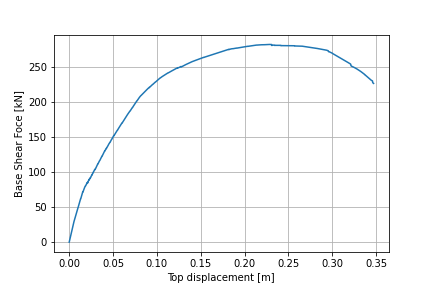

In [14]:
# Nonlinear Static Pushover Analysis of the inelastic frame
generate_inelastic_model() # generate a clean model
gravityForces, gravityDisps = do_gravity() # perform gravity analysis first

# create a load pattern for pushove analysis n
# Create the load pattern and apply loads
ops.timeSeries('Linear', 2)  # Define the timeSeries for the load pattern
ops.pattern('Plain', 2, 2)  # Define load pattern -- generalized

# lets use triangular force distribution
lat_forces = np.array([HStory1/HBuilding,1])
# normalize the laterial forces so that LoadFactor = BaseShear
lat_forces = lat_forces/np.sum(lat_forces) 
# apply the loads
ops.load(12, lat_forces[0],0,0)
ops.load(13, lat_forces[1],0,0)
# perform the pushover analysis
LoadFactor, DispCtrlNode = do_nspa(dmax=0.4, ctrlNode=13, ctrlDOF=1, nSteps=2000, IOflag=0)
plt.figure()
plt.plot(DispCtrlNode,LoadFactor)
plt.xlabel('Top displacement [m]')
plt.ylabel('Base Shear Foce [kN]')
plt.grid(True)

In [15]:
# Nonlinear Response History Analysis of the inelastic frame
generate_inelastic_model() # generate a clean model
gravityForces, gravityDisps = do_gravity() # perform gravity analysis first

record_filename = 'tools//test_motion.txt' # acceleration time history
dt = 0.01*sec # time step of record
A_g = np.loadtxt(record_filename) # load the file
gmDir = 1
xi = 0.05

# Set rayleigh damping based on first two modes
Lambda = np.asarray(ops.eigen(2))
Omega = Lambda ** 0.5
wi = Omega[0]
wj = Omega[1]
alpha = 2.0 * xi * wi * wj / (wi + wj)
beta = 2.0 * xi / (wi + wj)
ops.rayleigh(alpha, 0.0, 0.0, beta)

# Define the load pattern
load_tag_dynamic = 2 # tag for time series to use
pattern_tag_dynamic = 2 # tag for load pattern to use
values = list(-1 * A_g)  # should be negative
ops.timeSeries('Path', load_tag_dynamic, '-dt', dt, '-values', *values) # time series object
ops.pattern('UniformExcitation', pattern_tag_dynamic, gmDir, '-accel', load_tag_dynamic) # pattern object

tNode = [12, 13] # these are top floor nodes
bNode = [11, 12] # these are bottom floor nodes
Dc = 10 # global collapse limit we stop the analysis if this treshold is exceeded
Tmax = len(A_g)*dt + 10 # total analysis time, you may add a free vibration
mdrft = do_nrha(tNode, bNode, dt, Tmax, Dc, 1)

Model Built
Analysis is SUCCESSFULLY completed
Peak interstorey drift: 1.67% at floor 2
